$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/nevoagmon/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/nevoagmon/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/nevoagmon/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


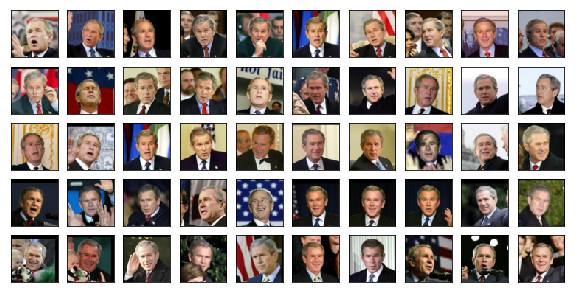

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 250, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=16000, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 250, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(1000, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Si

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

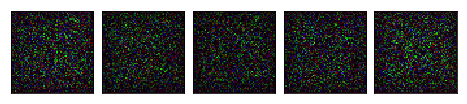

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 10, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.60it/s]
Discriminator loss: 1.1199170912013334
Generator loss:     2.227168090203229


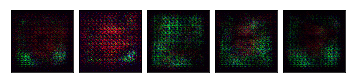

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.59it/s]
Discriminator loss: 0.6927399775561165
Generator loss:     4.138183088863597


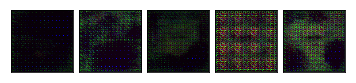

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: 0.9844335335142472
Generator loss:     3.3573967814445496


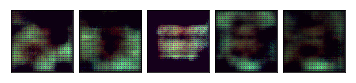

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.5920223435934853
Generator loss:     3.562423993559445


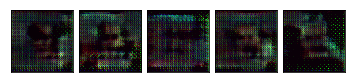

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.8324862613397486
Generator loss:     3.5629844314911785


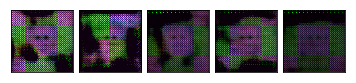

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.5320095034206614
Generator loss:     4.140137644375072


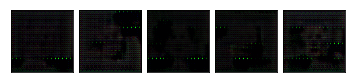

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.65it/s]
Discriminator loss: 0.36090442362953634
Generator loss:     5.050502524656408


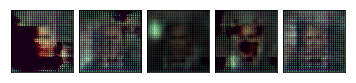

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.30890197788967805
Generator loss:     5.61627794714535


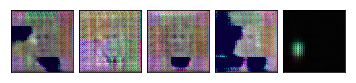

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.23808065210195148
Generator loss:     6.011551969191608


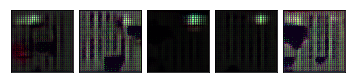

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.07it/s]
Discriminator loss: 0.23008038103580475
Generator loss:     7.303996015997494


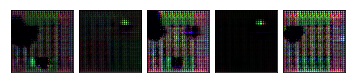

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.22901596128940582
Generator loss:     6.693839017082663


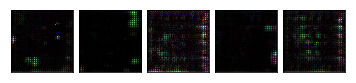

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.08it/s]
Discriminator loss: 0.16639047422829797
Generator loss:     6.972531248541439


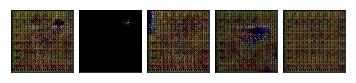

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.1457638327470597
Generator loss:     10.98580368827371


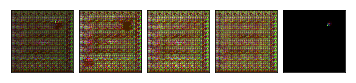

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.17726738531799877
Generator loss:     11.574974003960104


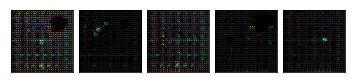

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.19389337871004553
Generator loss:     8.861024940715117


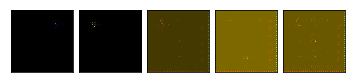

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.2614651927176644
Generator loss:     6.330096637501436


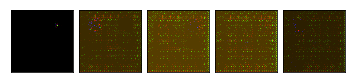

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.05it/s]
Discriminator loss: 0.10354389436542988
Generator loss:     10.25943972082699


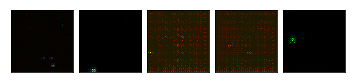

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.16379593882490606
Generator loss:     13.309687277849983


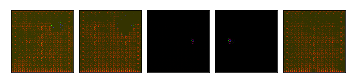

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.3065783920533517
Generator loss:     10.713175717522116


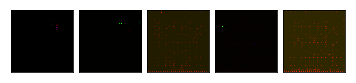

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.07667665468419299
Generator loss:     18.877668549032773


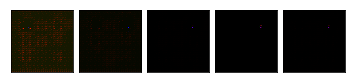

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.15082239841713624
Generator loss:     10.055899760302376


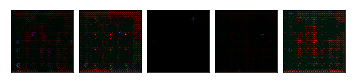

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.255817713763784
Generator loss:     17.845646633821374


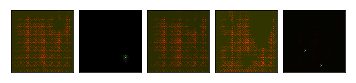

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.1801891458385131
Generator loss:     15.544340582454906


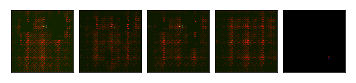

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.10506970128592323
Generator loss:     8.504005123587216


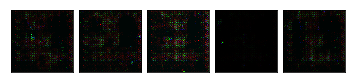

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.2598218632971539
Generator loss:     8.551724307677325


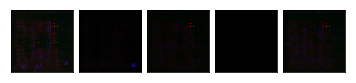

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.18156576660626075
Generator loss:     12.105077575234805


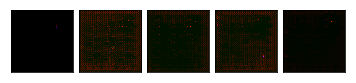

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.2278676129439298
Generator loss:     10.129061418421129


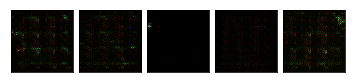

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.2356068250887534
Generator loss:     6.4640794641831345


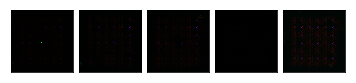

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.23569986092693665
Generator loss:     5.857231673072366


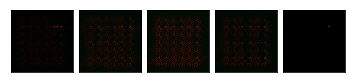

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.1862737057620988
Generator loss:     7.601444973665125


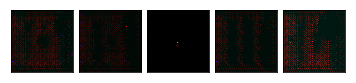

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.17966302122701616
Generator loss:     8.117006778717041


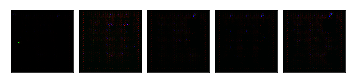

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.10866594796671587
Generator loss:     10.859804658328786


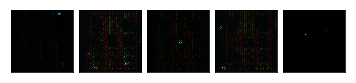

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.20743949360707226
Generator loss:     14.173487887663


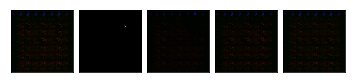

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.1361377353177351
Generator loss:     12.500825236825381


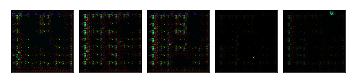

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.19273360730970607
Generator loss:     19.21708045286291


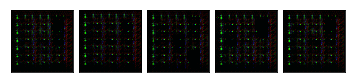

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 1.550587847828865
Generator loss:     7.859470788170309


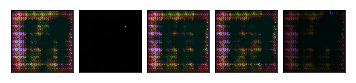

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.2916010438519366
Generator loss:     6.13893333603354


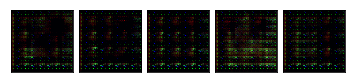

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.30501073686515584
Generator loss:     7.800218357759364


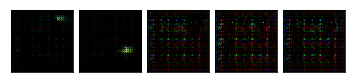

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.23125651741729064
Generator loss:     6.898441090303309


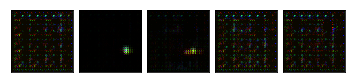

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.15249683927087224
Generator loss:     8.359603012309355


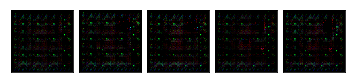

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.26256997357396517
Generator loss:     7.99076369229485


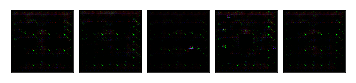

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.19709408283233643
Generator loss:     7.286667879889993


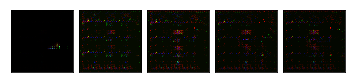

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.20992443228469176
Generator loss:     8.500214015736299


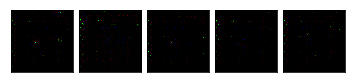

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.22970832709003897
Generator loss:     9.21878438837388


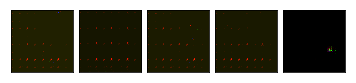

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.19422555890153437
Generator loss:     7.929419798009536


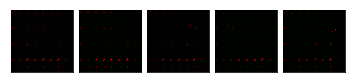

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.22216615913545384
Generator loss:     10.238254350774428


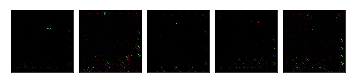

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.19342105485060634
Generator loss:     8.265480882981244


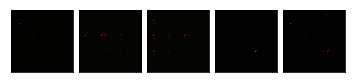

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.1522887421443182
Generator loss:     8.390263080596924


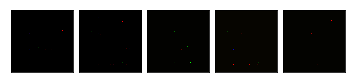

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.21347121850532644
Generator loss:     7.689610453212962


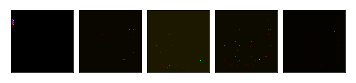

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.08it/s]
Discriminator loss: 0.2357638245996307
Generator loss:     7.458731398862951


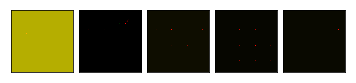

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.17380061175893335
Generator loss:     8.325041686787324


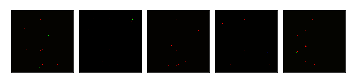

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.2384243616286446
Generator loss:     7.906268989338594


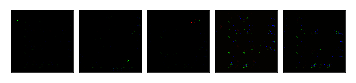

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.17227672171943328
Generator loss:     6.630669593811035


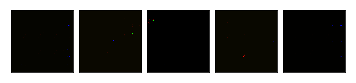

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.23534777409890117
Generator loss:     9.111319373635684


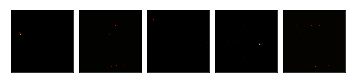

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.14279480497626698
Generator loss:     10.332072257995605


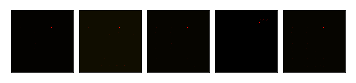

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.22439617970410516
Generator loss:     11.54728993247537


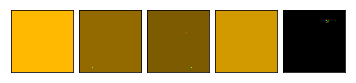

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.2311234062208849
Generator loss:     10.415063465342802


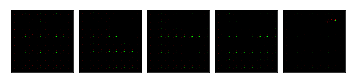

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.13704139257178588
Generator loss:     13.106426323161406


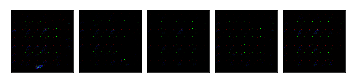

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.21923808841144338
Generator loss:     10.122797348920036


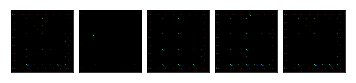

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.24030477027682698
Generator loss:     7.1102911724763755


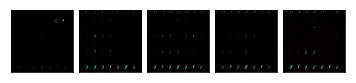

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.19422248093520894
Generator loss:     7.541175954482135


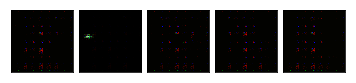

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.2436783550416722
Generator loss:     7.70376309226541


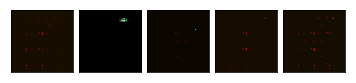

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.05it/s]
Discriminator loss: 0.2222866676747799
Generator loss:     7.069348026724422


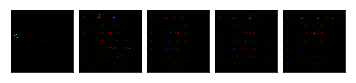

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.2102521711631733
Generator loss:     9.631259160883287


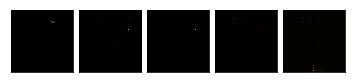

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.13119228288312168
Generator loss:     6.616432470433852


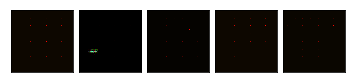

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.21282415837049484
Generator loss:     7.55670940174776


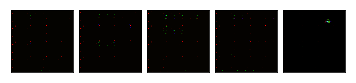

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.1996467599973959
Generator loss:     6.590482122757855


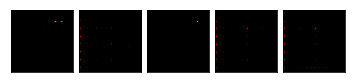

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.12411661621402292
Generator loss:     8.849930847392363


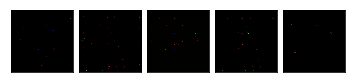

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.20978519583449645
Generator loss:     9.778976917266846


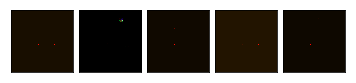

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.04it/s]
Discriminator loss: 0.1575649718151373
Generator loss:     9.250913143157959


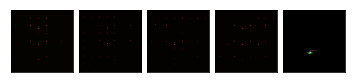

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.16541937935878248
Generator loss:     12.050164334914264


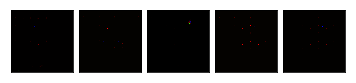

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.17216496125740163
Generator loss:     13.676152621998506


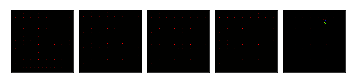

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.1189085348673603
Generator loss:     9.275069012361413


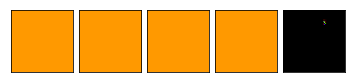

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.03it/s]
Discriminator loss: 0.05251765864736894
Generator loss:     14.948256380417767


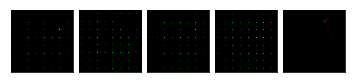

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.16938538542565176
Generator loss:     13.266484176411348


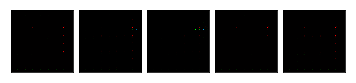

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.23735538913923152
Generator loss:     12.071289791780359


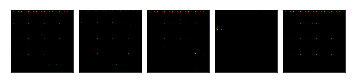

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.84it/s]
Discriminator loss: 0.221581212737981
Generator loss:     8.164360859814812


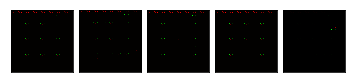

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.18834931228090734
Generator loss:     10.661807200487923


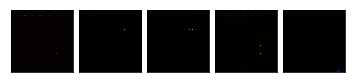

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.60it/s]
Discriminator loss: 0.18635336452108972
Generator loss:     12.515659500570859


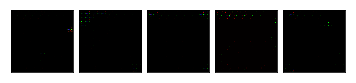

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.0981847898048513
Generator loss:     18.70989569495706


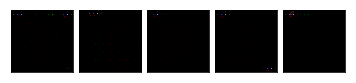

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: 0.14790352532530532
Generator loss:     14.575304872849408


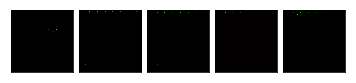

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.24910629606422255
Generator loss:     13.644937010372386


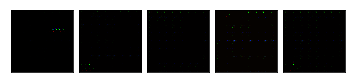

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.23508560306885662
Generator loss:     10.832218086018282


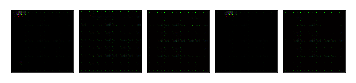

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.22736266343032613
Generator loss:     7.939501145306756


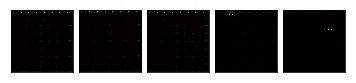

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.26024467399453416
Generator loss:     7.171178060419419


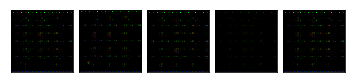

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.1623003916705356
Generator loss:     8.443194669835707


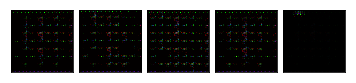

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.1187184808008811
Generator loss:     9.569613400627585


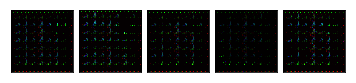

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.15440274950336008
Generator loss:     10.875050965477438


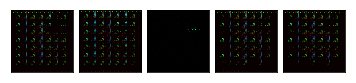

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.15047093130209865
Generator loss:     8.543617220485912


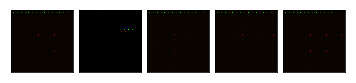

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 0.05679057691903675
Generator loss:     11.399038875804228


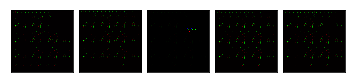

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.1770609343314872
Generator loss:     11.403838662540212


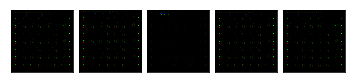

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.1524714906426037
Generator loss:     9.894664371714873


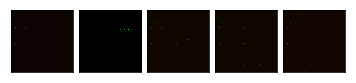

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
Discriminator loss: 0.20467895970625036
Generator loss:     13.006004557890051


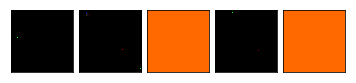

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.23015551707323859
Generator loss:     12.467030749601477


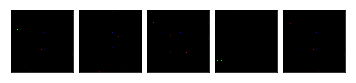

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
Discriminator loss: 0.1823322407024748
Generator loss:     8.09454833759981


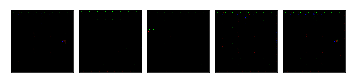

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.11011020269464045
Generator loss:     10.864045732161578


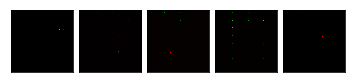

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: 0.17990956236334407
Generator loss:     17.10166981640984


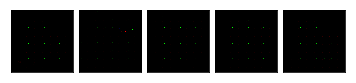

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.22769009037052884
Generator loss:     11.435263549580293


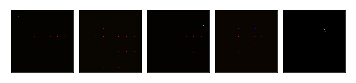

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.23091051771360285
Generator loss:     10.15190045973834


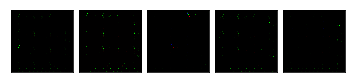

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.105152729241287
Generator loss:     9.828440525952507


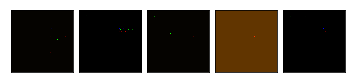

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


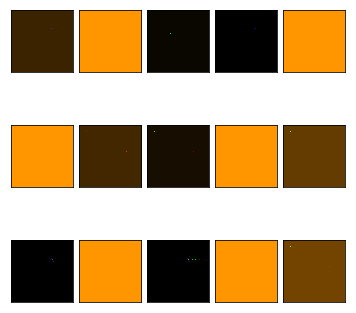

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


We maintain the gradient when we sample from the generator in the batch training function.
The reason is that when we are training we want the gradient so that we can optimize the result of the generator. In all other occasions we do not maintain the gradient so that we will not change its value and ruine the training.



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


We can't decide to stop training based on the generator loss being bellow a certain threshold because the loos of the generator and the loss of the descriminator are connected. We can imagine a situation where the loss of the generator is very low (so we would think to stop training) but in the next batch the descriminator will sudenlly improve and find new differences between the real and fake images therefore the loss of the generator will go back up. If we get into a situation where the loss of the descriminator is constant but the loos of the generator keeps improving then we are in a situation where the descriminator can no longer tell the difference between the real and fake images but the generator keeps making the images better and better in comparison to the real ones.



### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


The main difference between the results from the VAE and from the GAN is that the with the VAE we get a clear face with almost no background but with good details and with the GAN we get a better overall image in terms of the background and the face in it but with less fine details.
We think that the it is happaning because of the way the models are built, optimized and trained.
The VAE tries to extract the most importent and reoccuring features and convert them to a representation in the latent space, that is why we get a good result for the fine details of the face.
In comparison the GAN tries to optimize the generated image in relation to its ability to distinguish between a real and fake image, therefore it produces images that as a whole look similar to the dataset but the fine details are less importent.

